# Finetuning MoonShine in PyTorch

## Data
Using the Tensorflow mini speech command dataset to get up and running. See https://www.tensorflow.org/tutorials/audio/simple_audio for sources

In [1]:
# ensure vscode reloads python files
%load_ext autoreload
%reload_ext autoreload
from download_mini_speech_commands import downloadMiniSpeech

downloadMiniSpeech()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Zip file already exists, skipping download.
Dataset already extracted.


(16000,)


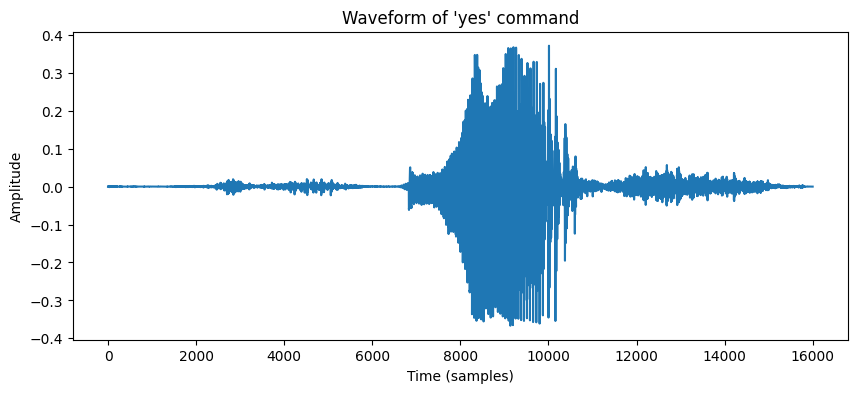

torch.Size([1, 1, 16000])


In [2]:
# load an example entry
import librosa
import torch
import matplotlib.pyplot as plt
import numpy as np

numSamplesPerSecond = 16000 # The sample rate, see https://librosa.org/doc/latest/glossary.html#term-sampling-rate
audio, sr = librosa.load("./data/mini_speech_commands/yes/0ab3b47d_nohash_0.wav", sr=numSamplesPerSecond)
print(audio.shape) # (16000,)

plt.figure(figsize=(10, 4))
plt.plot(audio)
plt.title("Waveform of 'yes' command")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.show()

audio = torch.tensor(audio)
audio = torch.reshape(audio, (1, 1, -1)) # (batch_size, num_channels, num_samples)
print(audio.shape) # (1, 16000)

## Preprocessor block

Moonshine base model `MoonShine(dim=288, innerdim=288, n_head=8, n_enc_layers=6, n_dec_layers=6)`

In [3]:
moonshineBaseConfig = {
    "preprocesserDims": 288,
    "innerDim": 288,
    "nHead": 8,
    "nEncoder": 6,
    "nDecoder": 6
}

In [4]:
from model import AudioPreprocessor, diskSizeOf

preprocessor = AudioPreprocessor(dim=moonshineBaseConfig["preprocesserDims"])
x = preprocessor(torch.randn(1, 1, 16000)) # (batch_size B, num_channels C, num_samples T)

# Test the preprocessor with the example audio
x = preprocessor(audio)
print(x.shape) # (B, C, T)
x = x.transpose(1, 2)
print(x.shape)

total_params = sum(p.numel() for p in preprocessor.parameters())
print(f"Total number of parameters in preprocessor: {total_params}, with disk size of {diskSizeOf(preprocessor)}")

torch.Size([1, 288, 40])
torch.Size([1, 40, 288])
Total number of parameters in preprocessor: 1696896, with disk size of ('6.47 MB', 1696896)


# Encoder Blocks

## RoPE

torch.Size([16, 144]) torch.Size([16, 144])


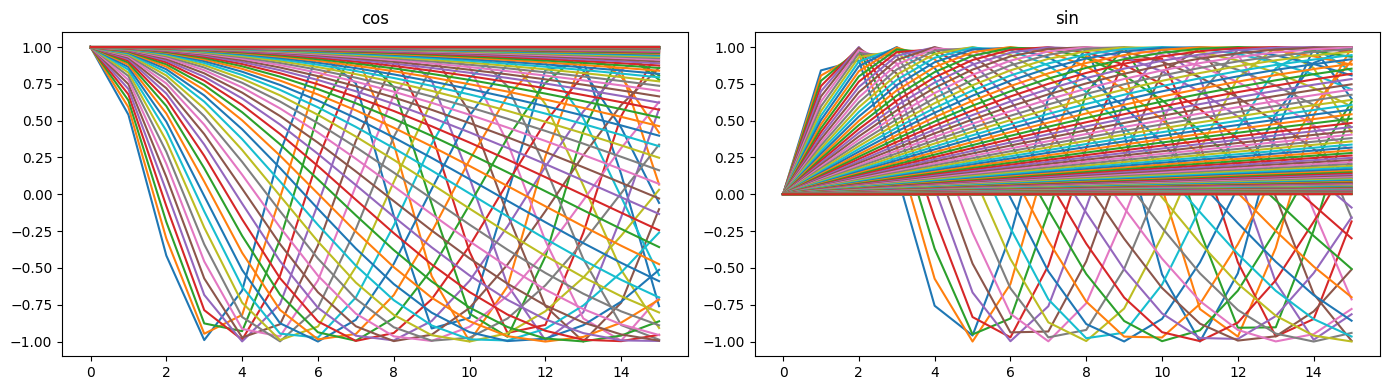

In [5]:

from model import generateRoPE

(cos, sin) = generateRoPE(16, 288)
cos, sin = cos.squeeze(0).squeeze(0), sin.squeeze(0).squeeze(0)
print(cos.shape, sin.shape)
# Plot the generated RoPE
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].plot(cos.numpy())
axes[0].set_title("cos")
axes[1].plot(sin.numpy())
axes[1].set_title("sin")
plt.tight_layout()
plt.show()


## MultiHead self attention with RoPE

torch.Size([32, 16, 256])
torch.Size([16, 16])


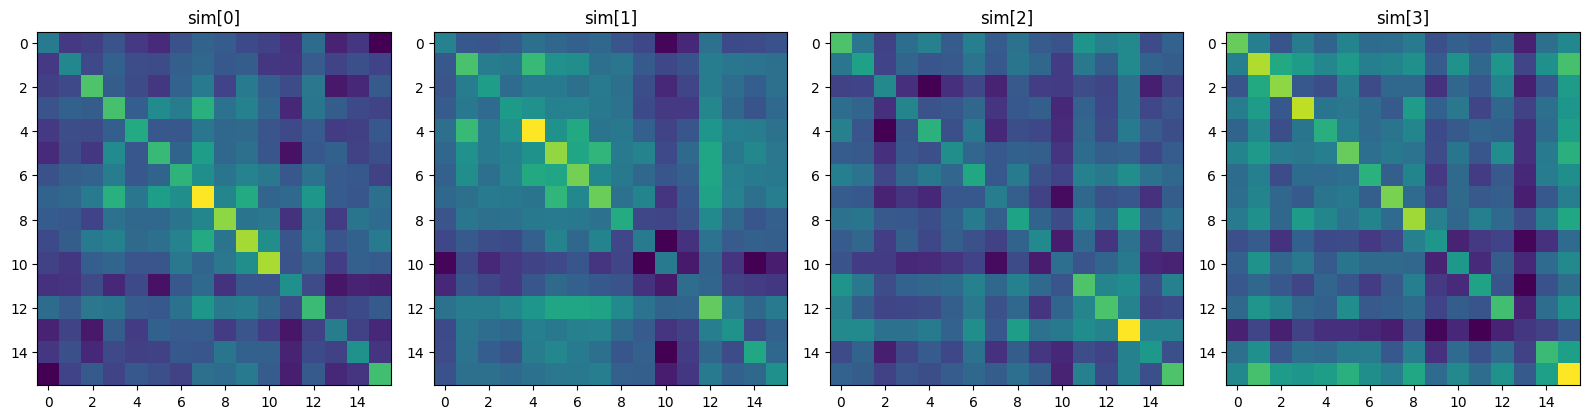

In [6]:
B, T, C = 32, 16, 256
x = torch.randn(B, T, C)

from model import MultiHeadSelfAttentionRoPE

sAttn = MultiHeadSelfAttentionRoPE(dim=C, innerDim=512, nHead=4, maxSeqLen=256)
attnOut = sAttn(x)
print(attnOut.shape)

# sanity check
attnOut = attnOut / attnOut.norm()
sim = attnOut @ attnOut.permute(0, 2, 1)
print(sim[0].shape)
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
    axes[i].imshow(sim[i].detach().numpy())
    axes[i].set_title(f"sim[{i}]")
plt.tight_layout()
plt.show()

## Encoder

In [7]:
from model import EncoderBlock

C = 256
nH = 4
x = torch.randn(B, T, C)
print(x.shape)
enc = EncoderBlock(dim=C, nHead=nH)
print(enc(x).shape)

torch.Size([32, 16, 256])
torch.Size([32, 16, 256])


## Decoder Block

In [14]:
from model import DecoderBlock

C = 256  # Dimension of the model
B, T = 32, 16  # Batch size and sequence length
vocabSize = 32768  # Example vocabulary size
tokens = torch.randint(0, vocabSize, (B, T))  # Random tokens for the decoder
emb = torch.nn.Embedding(vocabSize, C)  # Embedding layer for tokens
encoderHidden = torch.randn(B, T, C)  # Example encoder output

decoder = DecoderBlock(dim=C, innerDim=C)
decoderOut = decoder(emb(tokens), encoderHidden)
print(decoderOut.shape)  # Should be (B, T, vocabSize)

torch.Size([32, 16, 256])


# MoonShine

In [ ]:
from model import MoonShine

net = MoonShine()
out = net(audio)

print(out.shape)

print(diskSizeOf(net))

torch.Size([1, 40, 288])
('29.32 MB', 7684992)


## Load pretrained version

In [ ]:
from model import downloadPretrainedWeights
import h5py

preprocessor, encoder, decoder = downloadPretrainedWeights(variant="tiny")

/Users/aj/Projects/deep-learning/moonshine/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def printH5(item):
    with h5py.File(item, 'r') as f:
        def print_attrs(name, obj):
            if isinstance(obj, h5py.Dataset):
                print(f"{name}: shape={obj.shape}, dtype={obj.dtype}")
        f.visititems(print_attrs)

printH5(encoder)

layers/functional/layers/functional/layers/sequential/layers/dense/vars/0: shape=(288, 1152), dtype=float32
layers/functional/layers/functional/layers/sequential/layers/dense/vars/1: shape=(1152,), dtype=float32
layers/functional/layers/functional/layers/sequential/layers/dense_1/vars/0: shape=(1152, 288), dtype=float32
layers/functional/layers/functional/layers/sequential/layers/dense_1/vars/1: shape=(288,), dtype=float32
layers/functional/layers/layer_normalization/vars/0: shape=(288,), dtype=float32
layers/functional/layers/layer_normalization_1/vars/0: shape=(288,), dtype=float32
layers/functional/layers/mha_with_rope/key_dense/vars/0: shape=(288, 8, 36), dtype=float32
layers/functional/layers/mha_with_rope/output_dense/vars/0: shape=(8, 36, 288), dtype=float32
layers/functional/layers/mha_with_rope/query_dense/vars/0: shape=(288, 8, 36), dtype=float32
layers/functional/layers/mha_with_rope/value_dense/vars/0: shape=(288, 8, 36), dtype=float32
layers/functional_1/layers/functional/

In [ ]:
# check the rope embeddings
with h5py.File(encoder, 'r') as f:
    print(f["layers/rotary_embedding/vars/0"].shape)
    onnxRope = f["layers/rotary_embedding/vars/0"][:]
print(onnxRope)


(16,)
[1.0000000e+00 5.6234133e-01 3.1622776e-01 1.7782794e-01 1.0000000e-01
 5.6234129e-02 3.1622779e-02 1.7782794e-02 9.9999998e-03 5.6234132e-03
 3.1622779e-03 1.7782794e-03 1.0000000e-03 5.6234130e-04 3.1622779e-04
 1.7782794e-04]


In [ ]:
net.loadWeights(preprocessor, encoder, decoder)
print(diskSizeOf(net))

outEncoder = net(audio)
print(outEncoder.shape)

('29.32 MB', 7684992)
torch.Size([1, 40, 288])


# Onnx Runtime version of the original model

They seem to be using the [HF tokenizers](https://github.com/huggingface/tokenizers)

In [ ]:
from moonshine_onnx import MoonshineOnnxModel

onnxMoonshine = MoonshineOnnxModel(model_name="tiny")


In [ ]:
X = audio.numpy().reshape(1,-1)
hiddenState = onnxMoonshine.encoder.run(None, dict(input_values=X))[0]
print(hiddenState.shape)

(1, 40, 288)


In [ ]:
# compare encoder blocks
print(np.allclose(outEncoder.detach().numpy(), hiddenState))
diff = np.abs(outEncoder.detach().numpy() - hiddenState)
print(f"Mean difference: {np.mean(diff)}")
print(f"Norm ONNX enc: {np.linalg.norm(hiddenState)}")
print(f"Norm PyTorch enc: {outEncoder.norm()}")
print(outEncoder.shape, hiddenState.shape)
print(outEncoder[0, 1, :10])
print(hiddenState[0, 1, :10])

False
Mean difference: 0.06492692977190018
Norm ONNX enc: 57.64810562133789
Norm PyTorch enc: 57.63235855102539
torch.Size([1, 40, 288]) (1, 40, 288)
tensor([-0.1330, -0.1853,  0.0816,  0.3250, -0.4884,  0.3508,  0.3069,  0.2114,
        -0.0276,  0.1945], grad_fn=<SliceBackward0>)
[-0.14795464 -0.17220567  0.04767722  0.28897387 -0.37469268  0.28627253
  0.32711208  0.13294908  0.02383093  0.25639537]
